Make use of text in the item names.  Ths notebook does not adjust for seasonality.

In [1]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten, Dropout, concatenate, Input
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from utilities import series_to_supervised

ModuleNotFoundError: No module named 'utilities'

# Option 1: For local machine

In [ ]:
df_sales = pd.read_csv('./data/beach_restaurant_demand_forecast/sales_train.csv')
df_items = pd.read_csv('./data/beach_restaurant_demand_forecast/items.csv')
df_restaurant = pd.read_csv('./data/beach_restaurant_demand_forecast/restaurants.csv')
df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

# Option 2: For Google Colab
First download data from 
https://www.kaggle.com/datasets/jeffheaton/demand-forecasting-with-tabular-textual-images

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# import io
# df_sales = pd.read_csv(io.BytesIO(uploaded['sales_train.csv']))
# df_items = pd.read_csv(io.BytesIO(uploaded['items.csv']))
# df_restaurant = pd.read_csv(io.BytesIO(uploaded['resturants.csv']))

# df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

# Option 3: For kaggle notebooks

In [ ]:
# PATH_CSV = '/kaggle/input/demand-forecasting-with-tabular-textual-images/beach_demand_forecast'

# df_sales = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
# df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
# df_restaurant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))

# df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

## Explore data

In [ ]:
df_items

,id,store_id,name,kcal,cost
0,1,4,Chocolate Cake,554,6.71
1,2,4,Breaded Fish with Vegetables Meal,772,15.09
2,3,1,Sweet Fruity Cake,931,29.22
3,4,1,Amazing Steak Dinner with Rolls,763,26.42
4,5,5,Milk Cake,583,6.07
...,...,...,...,...,...
95,96,5,Blue Ribbon Fish with Bread Lunch,708,21.93
96,97,4,Original Fruity Cod with Bread and Vegetables ...,744,28.65
97,98,2,Original Sweet Milky Soft Drink,579,5.00
98,99,4,Frozen Tomato Soft Drink,423,5.32


In [ ]:
df_restaurant

,id,name
0,1,Bob's Diner
1,2,Beachfront Bar
2,3,Sweet Shack
3,4,Fou Cher
4,5,Corner Cafe
5,6,Surfs Up


In [ ]:
df_sales

,date,item_id,price,item_count
0,2019-01-01,3,29.22,2.0
1,2019-01-01,4,26.42,22.0
2,2019-01-01,12,4.87,7.0
3,2019-01-01,13,4.18,12.0
4,2019-01-01,16,3.21,136.0
...,...,...,...,...
109595,2021-12-31,96,21.93,0.0
109596,2021-12-31,97,28.65,0.0
109597,2021-12-31,98,5.00,0.0
109598,2021-12-31,99,5.32,0.0


## Load the Glove Embeddings

In [ ]:
# !wget -c "https://nlp.stanford.edu/data/glove.6B.zip"
# !unzip glove.6B.zip

In [ ]:
glove_file = './glove.6B/glove.6B.300d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
w2vec_model = KeyedVectors.load_word2vec_format(tmp_file)

/var/folders/nh/pknstycx55zf284hc5q5g2s8p2t_q7/T/ipykernel_11807/806106838.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


# NLP Demo

In [ ]:
w2vec_model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624220848083),
 ('throne', 0.5386103987693787),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.4980250597000122),
 ('mother', 0.4956442713737488),
 ('elizabeth', 0.483265221118927),
 ('kingdom', 0.47747087478637695),
 ('prince', 0.4668240249156952),
 ('wife', 0.46473273634910583)]

In [ ]:
# for each word in the dictionary of the words there is a vector presentation. The vector is 300-dimensions as stated in `'glove.6B.300d.txt'`
w2vec_model['dog']

array([-1.1043e-01,  8.1217e-01,  7.3668e-02,  1.9023e-01, -5.2888e-02,
        6.1468e-02,  1.6076e-01,  4.1302e-01, -3.0199e-01, -9.0827e-01,
        2.7504e-01, -3.1890e-02, -2.8842e-01,  2.3447e-01,  4.7679e-01,
        5.0124e-01,  2.9371e-01,  2.7029e-01,  5.4745e-02,  9.8038e-02,
        5.7116e-01,  3.6755e-01,  4.0734e-02,  3.4347e-01, -1.8256e-01,
       -2.8935e-01,  2.3826e-02, -1.9401e-01,  2.4444e-01,  1.3407e-01,
       -1.6494e-01, -2.6983e-01, -2.6234e-01, -2.1779e-01, -8.7528e-01,
        7.3822e-01, -8.7931e-02, -1.0876e-02, -2.6540e-01,  3.4668e-01,
       -5.5814e-01,  1.7591e-01,  1.6926e-01, -1.5725e-01, -5.0430e-01,
       -2.0100e-01,  6.6701e-01, -3.2518e-02,  4.5012e-02,  6.5675e-02,
       -1.6061e-01, -7.3363e-01,  2.4642e-01,  3.4325e-01,  2.1899e-01,
        4.8646e-02, -5.9987e-01, -5.8153e-02, -5.1694e-02, -5.7846e-01,
        3.0000e-01,  3.5078e-01,  4.6646e-01, -7.5309e-03,  1.0455e-01,
       -5.1016e-01, -5.5987e-02, -1.0295e-01, -2.6476e-01, -4.12

## Perform NLP Prediction

In [ ]:
def process_title(model, name: str):
    """for the given `name` (which is a string of words) calculate the vector representation. 
    The vector representation is the average of all vector representations of words in `name`. 
    Where are the vectors? In the `model`.
    
    EXAMPLE:
        name = "Chocolate Cake"
        get vector repr. for `Chocolate` and `Cake`. Then, average the vectors. 
    """
    v = None
    i = 0
    for word in name.split(' '):
        word = word.lower()
        if word == 'vegi': word = "vegetable"
        if word == 'smoothy': word = "malt"
        i+=1
        if v is None and word in model:
            v=model[word].copy()
        elif word in model:
            v+=model[word]
    v/=i
    return v

In [ ]:
process_title(w2vec_model, "Chocolate cake")

array([-0.0758825 ,  0.397085  , -0.008343  , -0.097215  , -0.56650496,
        0.11932001, -0.016513  , -0.23697   ,  0.29838   , -0.396955  ,
        0.2197465 , -0.86015   , -0.242585  ,  0.40074998, -0.47479498,
       -0.43400502,  0.066375  , -0.0704385 , -0.12736   ,  0.14479   ,
        0.30041   ,  0.152275  ,  0.081575  ,  0.561785  , -0.543175  ,
       -0.1077285 , -0.481505  ,  0.01428001, -0.293545  , -0.78625   ,
       -0.45320898,  0.5007    , -0.310665  , -0.33092   , -0.745745  ,
        0.799985  , -0.252535  ,  0.52907   , -0.2017775 ,  0.009743  ,
       -0.5865    , -0.05154   ,  0.15520845,  0.242735  ,  0.103693  ,
       -0.38421   ,  0.43168998, -0.393225  ,  0.126563  ,  0.266575  ,
        0.21884501,  0.019948  ,  0.319965  ,  0.388915  , -0.52665496,
       -0.16352999, -0.313815  ,  0.1312875 ,  0.741905  ,  0.07834   ,
        0.153882  , -0.0286585 ,  0.3736    , -0.19812521,  0.004449  ,
       -0.137377  ,  0.2927    ,  0.21911499, -0.56374   , -0.03

In [ ]:
item_lookup = {}
for i, name in zip(list(df_items.id), list(df_items.name)):
    v = process_title(w2vec_model, name)
    item_lookup[i] = v

print(len(item_lookup))

100


Join the items and sales tables so that we can look up the store id for each item.

In [ ]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2019-01-01,0.0
1,1,4,2019-01-02,0.0
2,1,4,2019-01-03,0.0
3,1,4,2019-01-04,0.0
4,1,4,2019-01-05,0.0


In [ ]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear
df_train

,item,store,date,sales,dow,doy
0,1,4,2019-01-01,0.0,1,1
1,1,4,2019-01-02,0.0,2,2
2,1,4,2019-01-03,0.0,3,3
3,1,4,2019-01-04,0.0,4,4
4,1,4,2019-01-05,0.0,5,5
...,...,...,...,...,...,...
109595,100,2,2021-12-27,0.0,0,361
109596,100,2,2021-12-28,0.0,1,362
109597,100,2,2021-12-29,0.0,2,363
109598,100,2,2021-12-30,0.0,3,364


## Build the sequence data

In [ ]:
window = 29 # we use `window` history to predict the future
future_span = 30 # we are predicting this timestamp in the future

In [ ]:
df_train.drop('date', axis=1).columns

Index(['item', 'store', 'sales', 'dow', 'doy'], dtype='object')

In [ ]:
series2 = series_to_supervised(df_train.drop('date', axis=1), groupby_cols=["store", "item"], value_cols=["sales", "doy", "dow"],
                                window=window, lag=future_span, dropnan=True)
series2.head()

,item,store,sales(t),dow(t),doy(t),sales(t-29),doy(t-29),dow(t-29),sales(t-28),doy(t-28),...,dow(t-3),sales(t-2),doy(t-2),dow(t-2),sales(t-1),doy(t-1),dow(t-1),sales(t+30),doy(t+30),dow(t+30)
29,1,4,0.0,2,30,0.0,1.0,1.0,0.0,2.0,...,6.0,0.0,28.0,0.0,0.0,29.0,1.0,0.0,60.0,4.0
30,1,4,0.0,3,31,0.0,2.0,2.0,0.0,3.0,...,0.0,0.0,29.0,1.0,0.0,30.0,2.0,0.0,61.0,5.0
31,1,4,0.0,4,32,0.0,3.0,3.0,0.0,4.0,...,1.0,0.0,30.0,2.0,0.0,31.0,3.0,0.0,62.0,6.0
32,1,4,0.0,5,33,0.0,4.0,4.0,0.0,5.0,...,2.0,0.0,31.0,3.0,0.0,32.0,4.0,0.0,63.0,0.0
33,1,4,0.0,6,34,0.0,5.0,5.0,0.0,6.0,...,3.0,0.0,32.0,4.0,0.0,33.0,5.0,0.0,64.0,1.0


We will predict with sales, and our engineered features.

In [ ]:
def filter_columns(df, target_format, except_col=None):
    target_cols = []
    for c in df.columns:
        if (target_format in c) and (c != except_col):
            target_cols.append(c)
    return df[target_cols]

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series2[labels_col]

# Get sales sequences
sales_series = filter_columns(series2, "sales", labels_col)

# Day of week as a number
dow_series = filter_columns(series2, "dow", "dow(t+%d)" % future_span)

# Get day of year sequences
doy_series = filter_columns(series2, "doy", "doy(t+%d)" % future_span)

t1 = sales_series.values.reshape(sales_series.values.shape + (1,))
t2 = dow_series.values.reshape(dow_series.values.shape + (1,)) 
t3 = doy_series.values.reshape(doy_series.values.shape + (1,))

# Create x1, which consists features `sales`, `dow`, `doy`
x1 = np.concatenate([t1,t2,t3],axis=2)

# Create x2, which is the encoding of items according to the word2vec model
vec_size = w2vec_model['test'].shape[0]
lst = []
for item in list(series2['item']):
    lst.append(item_lookup[item])
x2 = np.concatenate(lst).reshape((series2.shape[0],vec_size))

# Combine all features
x = [x1,x2]
x= [x1]

In [ ]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(103700, 30, 1)
(103700, 30, 1)
(103700, 30, 1)


Extract the predictors (x sequences) and the label (future prediction)

In [ ]:
TEST_SIZE = 0.4

mask = np.random.random(size=x[0].shape[0])<TEST_SIZE

X_train = []
X_valid = []

for subx in x:
    X_train.append(subx[~mask])
    X_valid.append(subx[mask])

Y_train = labels.values[~mask]
Y_valid = labels.values[mask]

print('Train set shape x1:', X_train[0].shape)
# print('Train set shape x2:', X_train[1].shape)
print('Validation set shape x1:', X_valid[0].shape)
# print('Validation set shape x2:', X_valid[1].shape)

Train set shape x1: (62093, 30, 3)
Validation set shape x1: (41607, 30, 3)


Construct the neural network.

In [ ]:
epochs = 500
batch = 256
lr = 0.0003

def build_base_branch():
    A1 = Input(shape=(X_train[0].shape[1], X_train[0].shape[2]),name='A1')
    A2 = Conv1D(filters=64, kernel_size=8, activation='relu')(A1)
    A3 = MaxPooling1D(pool_size=2)(A2)
    A4 = Flatten()(A3)
    A5 = Dense(50, activation='relu')(A4)
    A6 = Dropout(0.2)(A5)
    return A1, A6

def build_nlp_branch():
    B1 = Input(shape=X_train[1].shape[1],name='B1')
    B2 = Dense(16, activation='relu', name='B2')(B1)
    return B1, B2

def create_model(add_nlp_branch:bool=True) -> Model:
    """Create a deep learning model and return the model object. Model object could be later using for training/testing.

    Args:
        add_nlp_branch (bool, optional): Add the NLP branch to the deep learning model if True. Defaults to True.

    Returns:
        Model: a Tensorflow Keras model that could be used for training/testing.
    """
    adam = tf.keras.optimizers.Adam(lr)

    model = Sequential()
    
    A1, A6 = build_base_branch()

    if add_nlp_branch:
        B1, B2 = build_nlp_branch()
        M1 = concatenate([A6,B2])
        M2 = Dense(1,name='M2')(M1)
        model = Model(inputs=[A1, B1],outputs=[M2])
    else:
        D1 = Dense(1,name='D1')(A6)
        model = Model(inputs=[A1],outputs=[D1])

    model.compile(loss='mse', optimizer=adam)
    model.summary()
    return model

In [ ]:
model = create_model(add_nlp_branch=False)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A1 (InputLayer)              [(None, 30, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 64)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                35250     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
D1 (Dense)                   (None, 1)                 51    

2023-04-26 12:46:11.698070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fit the neural network.

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(X_train, Y_train, callbacks=[monitor],
    validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500


2023-04-26 12:46:11.930211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


1941/1941 - 6s - loss: 134.6824 - val_loss: 74.4306
Epoch 2/500
1941/1941 - 4s - loss: 97.4251 - val_loss: 56.8176
Epoch 3/500
1941/1941 - 3s - loss: 97.7797 - val_loss: 60.9641
Epoch 4/500
1941/1941 - 5s - loss: 93.6472 - val_loss: 71.9340
Epoch 5/500
1941/1941 - 4s - loss: 92.1094 - val_loss: 55.0680
Epoch 6/500
1941/1941 - 4s - loss: 83.1955 - val_loss: 74.1412
Epoch 7/500
1941/1941 - 5s - loss: 90.6578 - val_loss: 55.5446
Epoch 8/500
1941/1941 - 3s - loss: 81.5006 - val_loss: 49.2898
Epoch 9/500
1941/1941 - 4s - loss: 82.6362 - val_loss: 53.6675
Epoch 10/500
1941/1941 - 4s - loss: 84.8991 - val_loss: 55.6281
Epoch 11/500
1941/1941 - 5s - loss: 86.5644 - val_loss: 50.2637
Epoch 12/500
1941/1941 - 4s - loss: 87.8663 - val_loss: 53.6792
Epoch 13/500
1941/1941 - 3s - loss: 80.4590 - val_loss: 59.2373
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


Predict and evaluate the validation data.

In [ ]:
cnn_train_pred = model.predict(X_train)
cnn_valid_pred = model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 8.0166741997662
Validation rmse: 7.020665599645906


Plot the training curve.

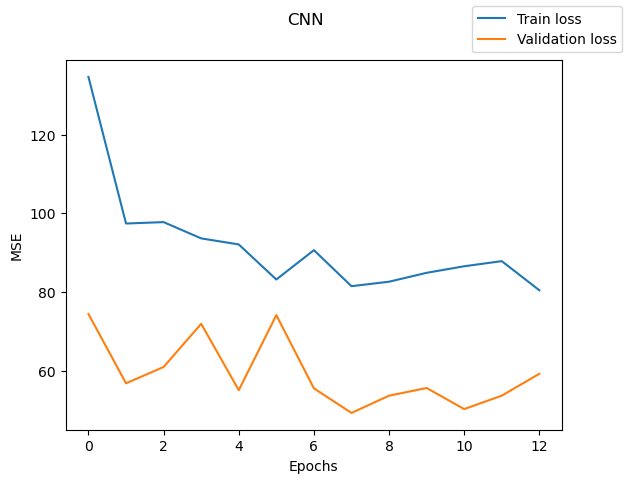

In [ ]:
fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()